In [53]:
import torch
from torch import nn

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using {device}")

You are using cuda


### InceptionNet Modelinin İncelenmesi
InceptionNet, diğer adıyla GoogleNet modeli Google ekibi tarafından ortaya çıkarılmıştır. Temel motivasyon sınıflandırıcı modellerin boyutunu arttırmadan daha etkili bir model oluşturmaktır. (Makaledeki aktarıma göre daha derin model oluşturmaktır.) Yazarların esinlendikleri husustan biri de Network in Network çalışmasıdır. Bu mimariden esinlenilerek oluşturulan model döneminin sınıflandırıcı en iyi modeli ile karşılaştırıldığında 12 kat daha az parametre kullanılmış ve doğruluk olarak ilgili modeli geçmiştir. Model Serre ve arkadaşlarının primat görsel korteksinin bir nörobilim modelinden esinlenmiştir. Bundan farkı Gabor filtreleri kullanılmamış onun yerine 1x1'lik konvolüsyonlarla boyutlarda azaltmalar yapılmıştır. 1x1'lik konvolüsyonların hemen arkasına 3x3'lük ve 5x5'lik konvolüsyonlar eklenerek özellik çıkarma konusunda başarı sağlanmıştır.Ayrıca aralara eklenen aktivasyon fonksiyonları karar yüzeyini daha ayrılabilir kılacaktır. Burada 1x1'lik konvolüsyonların 2 amacı vardır:
    * Hesaplama bottlenecklerini ortadan kaldırmak için boyut azaltma olarak kullanılır.
    * Ağ derinliğini ve genişliğini arttırmayı sağlar.

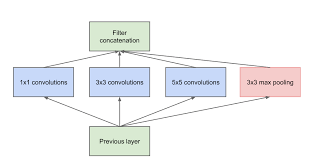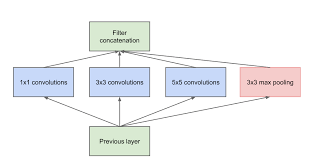

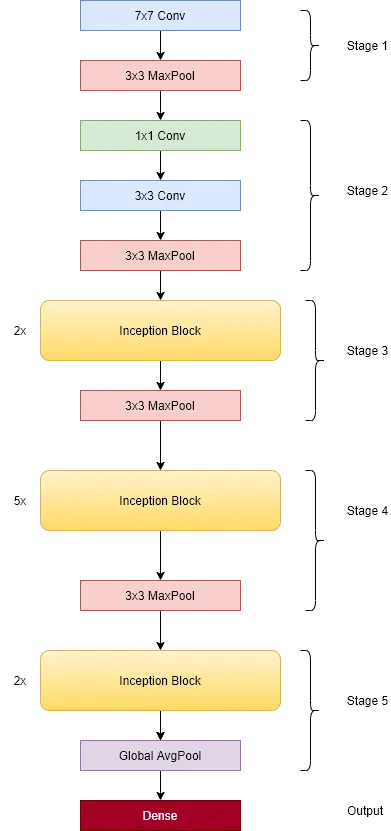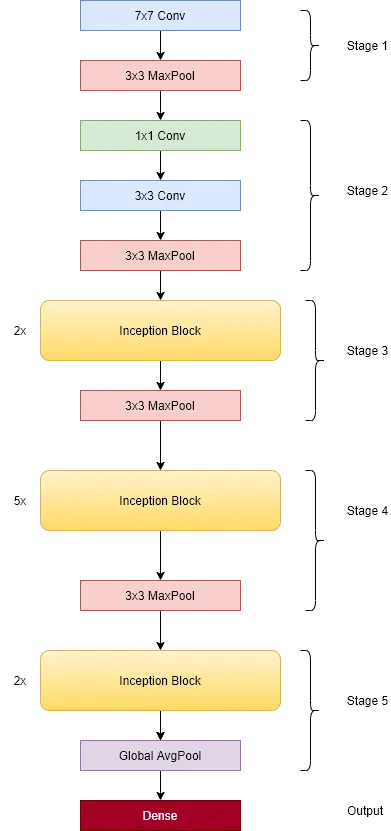

In [ ]:
import torch.nn.functional as F
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, f1, f3_in, f3_out, f5_in, f5_out, pool_proj) -> None:
        super(InceptionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, f1, kernel_size = 1)
        self.pool_proj_block = self.pool_project(in_channels,pool_proj)
        self.three_by_three_block = self.create_3x3(in_channels,f3_in, f3_out)
        self.five_by_five_block = self.create_5x5(in_channels,f5_in, f5_out)
    def pool_project(self,in_channels,pool_proj) -> nn.Sequential:
        return nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_channels, pool_proj,kernel_size = 1)
        )
    def create_3x3(self,in_channels,f3_in, f3_out) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, f3_in, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(f3_in, f3_out, kernel_size=3, padding=1)
        )
        
    def create_5x5(self,in_channels,f5_in, f5_out) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, f5_in, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(f5_in, f5_out, padding = 2, kernel_size = 5)
        )
    def forward(self, x) -> torch.Tensor:
        x0 = F.relu(self.conv(x))
        x1 = F.relu(self.pool_proj_block(x))
        x2 = F.relu(self.three_by_three_block(x))
        x3 = F.relu(self.five_by_five_block(x))
        return torch.cat([x0,x1, x2, x3], dim=1)

In [ ]:
class Inception(nn.Module):
    def __init__(self) -> None:
        super(Inception, self).__init__()
         # Başlangıç Konvolüsyon Katmanı
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # 1x1 ve 3x3 konvolüsyon blokları
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Inception blokları
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        # Ortalama Havuzlama + Tam Bağlantılı Katman
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, 1000) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [57]:
model = Inception().to(device)
model

Inception(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (inception3a): InceptionBlock(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (pool_proj_block): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (1): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (three_by_three_block): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (five_by_five_blo

In [58]:
rand_tens = torch.randn(1,3,224,224).to(device)
res = model(rand_tens)
res.shape

torch.Size([1, 1000])